In [3]:
# ================================================================
# ANALYSES AVANCÉES ET VISUALISATIONS SUPPLÉMENTAIRES
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("🔬 ANALYSES AVANCÉES - OBSERVATOIRE TDAH FRANCE")
print("="*60)

# ================================================================
# 1. ANALYSE DE COMPLÉTUDE DES DONNÉES
# ================================================================

def analyser_completude():
    print("\n📊 ANALYSE DE COMPLÉTUDE DES DONNÉES")
    print("-" * 40)
    
    # Régions attendues (France métropolitaine + Corse)
    regions_attendues = set([
        'Île-de-France', 'Provence-Alpes-Côte d\'Azur', 'Auvergne-Rhône-Alpes',
        'Hauts-de-France', 'Nouvelle-Aquitaine', 'Occitanie', 'Grand Est',
        'Pays de la Loire', 'Normandie', 'Bretagne', 'Bourgogne-Franche-Comté',
        'Centre-Val de Loire', 'Corse'
    ])
    
    # Vérification par dataset
    datasets = {
        'Densité pédopsychiatres': df_densite,
        'Pauvreté régionale': df_pauvrete, 
        'Méthylphénidate': df_methylphenidate,
        'Population INSEE': df_population
    }
    
    completude_report = {}
    for nom, df in datasets.items():
        regions_presentes = set(df['region'].unique())
        manquantes = regions_attendues - regions_presentes
        taux_completude = len(regions_presentes) / len(regions_attendues) * 100
        
        completude_report[nom] = {
            'présentes': len(regions_presentes),
            'manquantes': list(manquantes),
            'taux_completude': taux_completude
        }
        
        print(f"\n{nom}:")
        print(f"  ✅ Régions présentes: {len(regions_presentes)}/13")
        print(f"  📊 Taux de complétude: {taux_completude:.1f}%")
        if manquantes:
            print(f"  ❌ Régions manquantes: {manquantes}")
    
    return completude_report

completude = analyser_completude()

# ================================================================
# 2. INDICATEURS DÉRIVÉS ET SCORES COMPOSITES
# ================================================================

def creer_indicateurs_derives():
    print("\n🧮 CRÉATION D'INDICATEURS DÉRIVÉS")
    print("-" * 35)
    
    # Merge de tous les datasets
    master_df = df_population.copy()
    master_df = master_df.merge(df_densite[['region', 'densite_podopsychiatres_pour_100k']], 
                               on='region', how='left')
    master_df = master_df.merge(df_pauvrete[['region', 'taux_pauvrete_enfants', 'revenus_medians']], 
                               on='region', how='left')
    
    # Indicateurs dérivés
    master_df['densite_pop_km2'] = master_df['population_totale'] / master_df['superficie_km2']
    master_df['ratio_enfants'] = master_df['population_0_17'] / master_df['population_totale'] * 100
    master_df['pedopsychiatres_absolus'] = (master_df['densite_podopsychiatres_pour_100k'] * 
                                           master_df['population_0_17'] / 100000)
    
    # Score de vulnérabilité TDAH (plus élevé = plus vulnérable)
    # Normalisation des variables (0-1)
    scaler = StandardScaler()
    
    # Variables pour le score (inversées si nécessaire)
    score_vars = master_df[['taux_pauvrete_enfants', 'densite_podopsychiatres_pour_100k']].copy()
    score_vars['densite_inverse'] = 1 / (score_vars['densite_podopsychiatres_pour_100k'] + 0.1)
    
    score_normalized = scaler.fit_transform(score_vars[['taux_pauvrete_enfants', 'densite_inverse']])
    master_df['score_vulnerabilite_tdah'] = np.mean(score_normalized, axis=1)
    
    print(f"✅ {len(master_df)} régions avec indicateurs dérivés créés")
    return master_df

master_data = creer_indicateurs_derives()

# ================================================================
# 3. ANALYSES DE CORRÉLATION AVANCÉES
# ================================================================

def analyser_correlations():
    print("\n📈 ANALYSES DE CORRÉLATIONS")
    print("-" * 30)
    
    # Variables d'intérêt
    vars_numeriques = [
        'population_totale', 'population_0_17', 'densite_population',
        'densite_podopsychiatres_pour_100k', 'taux_pauvrete_enfants', 
        'revenus_medians', 'ratio_enfants', 'score_vulnerabilite_tdah'
    ]
    
    corr_matrix = master_data[vars_numeriques].corr()
    
    # Affichage des corrélations significatives
    correlations_fortes = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:  # Corrélation forte
                correlations_fortes.append({
                    'var1': corr_matrix.columns[i],
                    'var2': corr_matrix.columns[j],
                    'correlation': corr_val
                })
    
    print("🔍 Corrélations fortes détectées (|r| > 0.5):")
    for corr in correlations_fortes:
        print(f"  {corr['var1']} ↔ {corr['var2']}: r={corr['correlation']:.3f}")
    
    return corr_matrix

corr_matrix = analyser_correlations()

# ================================================================
# 4. SEGMENTATION DES RÉGIONS (CLUSTERING)
# ================================================================

def segmenter_regions():
    print("\n🎯 SEGMENTATION DES RÉGIONS")
    print("-" * 28)
    
    # Variables pour le clustering
    cluster_vars = [
        'densite_podopsychiatres_pour_100k', 'taux_pauvrete_enfants', 
        'population_0_17', 'revenus_medians'
    ]
    
    # Normalisation
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(master_data[cluster_vars])
    
    # K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    master_data['cluster'] = clusters
    
    # Analyse des profils de clusters
    cluster_profiles = master_data.groupby('cluster')[cluster_vars + ['region']].agg({
        'densite_podopsychiatres_pour_100k': 'mean',
        'taux_pauvrete_enfants': 'mean', 
        'population_0_17': 'mean',
        'revenus_medians': 'mean',
        'region': 'count'
    })
    
    # Attribution de noms aux clusters
    cluster_names = {
        0: "Équilibrées",
        1: "Sous-dotées", 
        2: "Privilégiées",
        3: "Défavorisées"
    }
    
    print("📊 Profils des clusters identifiés:")
    for i in range(4):
        regions_cluster = master_data[master_data['cluster'] == i]['region'].tolist()
        print(f"\n🔸 Cluster {i} - {cluster_names[i]} ({len(regions_cluster)} régions):")
        print(f"   Régions: {', '.join(regions_cluster[:3])}{'...' if len(regions_cluster) > 3 else ''}")
        print(f"   Densité pédopsychiatres: {cluster_profiles.loc[i, 'densite_podopsychiatres_pour_100k']:.1f}")
        print(f"   Pauvreté enfants: {cluster_profiles.loc[i, 'taux_pauvrete_enfants']:.1f}%")
    
    return clusters, cluster_names

clusters, cluster_names = segmenter_regions()

# ================================================================
# 5. ANALYSE TEMPORELLE AVANCÉE DU MÉTHYLPHÉNIDATE
# ================================================================

def analyser_tendances_methylphenidate():
    print("\n📅 ANALYSE TEMPORELLE AVANCÉE - MÉTHYLPHÉNIDATE")
    print("-" * 48)
    
    # Calcul des taux de croissance par région
    croissance_regions = []
    
    for region in df_methylphenidate['region'].unique():
        data_region = df_methylphenidate[df_methylphenidate['region'] == region].sort_values('annee')
        if len(data_region) >= 2:
            conso_debut = data_region.iloc[0]['consommation_ddd_par_1000_hab']
            conso_fin = data_region.iloc[-1]['consommation_ddd_par_1000_hab']
            croissance = ((conso_fin - conso_debut) / conso_debut) * 100
            
            croissance_regions.append({
                'region': region,
                'croissance_2020_2023': croissance,
                'conso_2023': conso_fin,
                'evolution_absolue': conso_fin - conso_debut
            })
    
    croissance_df = pd.DataFrame(croissance_regions).sort_values('croissance_2020_2023', ascending=False)
    
    print("📊 Top 5 régions avec plus forte croissance 2020-2023:")
    for i, row in croissance_df.head().iterrows():
        print(f"  {row['region']}: +{row['croissance_2020_2023']:.1f}% "
              f"(+{row['evolution_absolue']:.1f} DDD/1000 hab)")
    
    # Prédiction simple (régression linéaire)
    print(f"\n🔮 PRÉDICTIONS 2024 (régression linéaire):")
    predictions_2024 = []
    
    for region in df_methylphenidate['region'].unique():
        data_region = df_methylphenidate[df_methylphenidate['region'] == region].sort_values('annee')
        if len(data_region) >= 3:
            # Régression linéaire simple
            x = np.array(data_region['annee'])
            y = np.array(data_region['consommation_ddd_par_1000_hab'])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            pred_2024 = slope * 2024 + intercept
            predictions_2024.append({
                'region': region,
                'prediction_2024': pred_2024,
                'r_squared': r_value**2
            })
    
    pred_df = pd.DataFrame(predictions_2024).sort_values('prediction_2024', ascending=False)
    print("Top 3 régions prédites pour 2024:")
    for i, row in pred_df.head(3).iterrows():
        print(f"  {row['region']}: {row['prediction_2024']:.1f} DDD/1000 hab (R²={row['r_squared']:.2f})")
    
    return croissance_df, pred_df

croissance_df, pred_df = analyser_tendances_methylphenidate()

# ================================================================
# 6. CRÉATION D'UN TABLEAU DE BORD SYNTHÉTIQUE
# ================================================================

def creer_tableau_bord():
    print("\n📋 TABLEAU DE BORD SYNTHÉTIQUE")
    print("-" * 32)
    
    # KPIs nationaux
    kpis = {
        'Population 0-17 ans totale': f"{master_data['population_0_17'].sum():,}",
        'Densité pédopsychiatres moyenne': f"{master_data['densite_podopsychiatres_pour_100k'].mean():.1f} pour 100k",
        'Taux pauvreté enfants moyen': f"{master_data['taux_pauvrete_enfants'].mean():.1f}%",
        'Consommation méthylphénidate 2023': f"{df_methylphenidate[df_methylphenidate['annee']==2023]['consommation_ddd_par_1000_hab'].mean():.1f} DDD/1000 hab",
        'Écart-type densité pédopsychiatres': f"{master_data['densite_podopsychiatres_pour_100k'].std():.1f}",
        'Régions les plus vulnérables': f"{len(master_data[master_data['score_vulnerabilite_tdah'] > 0.5])}/13"
    }
    
    print("🎯 KPIs NATIONAUX:")
    for kpi, valeur in kpis.items():
        print(f"  • {kpi}: {valeur}")
    
    # Régions d'attention prioritaire
    regions_prioritaires = master_data.nlargest(3, 'score_vulnerabilite_tdah')['region'].tolist()
    print(f"\n🚨 RÉGIONS D'ATTENTION PRIORITAIRE:")
    for i, region in enumerate(regions_prioritaires, 1):
        score = master_data[master_data['region'] == region]['score_vulnerabilite_tdah'].iloc[0]
        print(f"  {i}. {region} (score: {score:.2f})")
    
    return kpis

dashboard_kpis = creer_tableau_bord()

print(f"\n🎉 ANALYSES AVANCÉES TERMINÉES!")
print("="*50)
print("✅ Indicateurs dérivés créés")  
print("✅ Corrélations analysées")
print("✅ Segmentation des régions effectuée")
print("✅ Tendances et prédictions calculées")
print("✅ Tableau de bord généré")


🔬 ANALYSES AVANCÉES - OBSERVATOIRE TDAH FRANCE

📊 ANALYSE DE COMPLÉTUDE DES DONNÉES
----------------------------------------

Densité pédopsychiatres:
  ✅ Régions présentes: 13/13
  📊 Taux de complétude: 100.0%

Pauvreté régionale:
  ✅ Régions présentes: 13/13
  📊 Taux de complétude: 100.0%

Méthylphénidate:
  ✅ Régions présentes: 13/13
  📊 Taux de complétude: 100.0%

Population INSEE:
  ✅ Régions présentes: 13/13
  📊 Taux de complétude: 100.0%

🧮 CRÉATION D'INDICATEURS DÉRIVÉS
-----------------------------------
✅ 13 régions avec indicateurs dérivés créés

📈 ANALYSES DE CORRÉLATIONS
------------------------------
🔍 Corrélations fortes détectées (|r| > 0.5):
  population_totale ↔ population_0_17: r=0.988
  population_totale ↔ densite_population: r=-0.775
  population_0_17 ↔ densite_population: r=-0.760
  densite_podopsychiatres_pour_100k ↔ score_vulnerabilite_tdah: r=-0.641
  taux_pauvrete_enfants ↔ ratio_enfants: r=0.591
  taux_pauvrete_enfants ↔ score_vulnerabilite_tdah: r=0.751

🎯 S

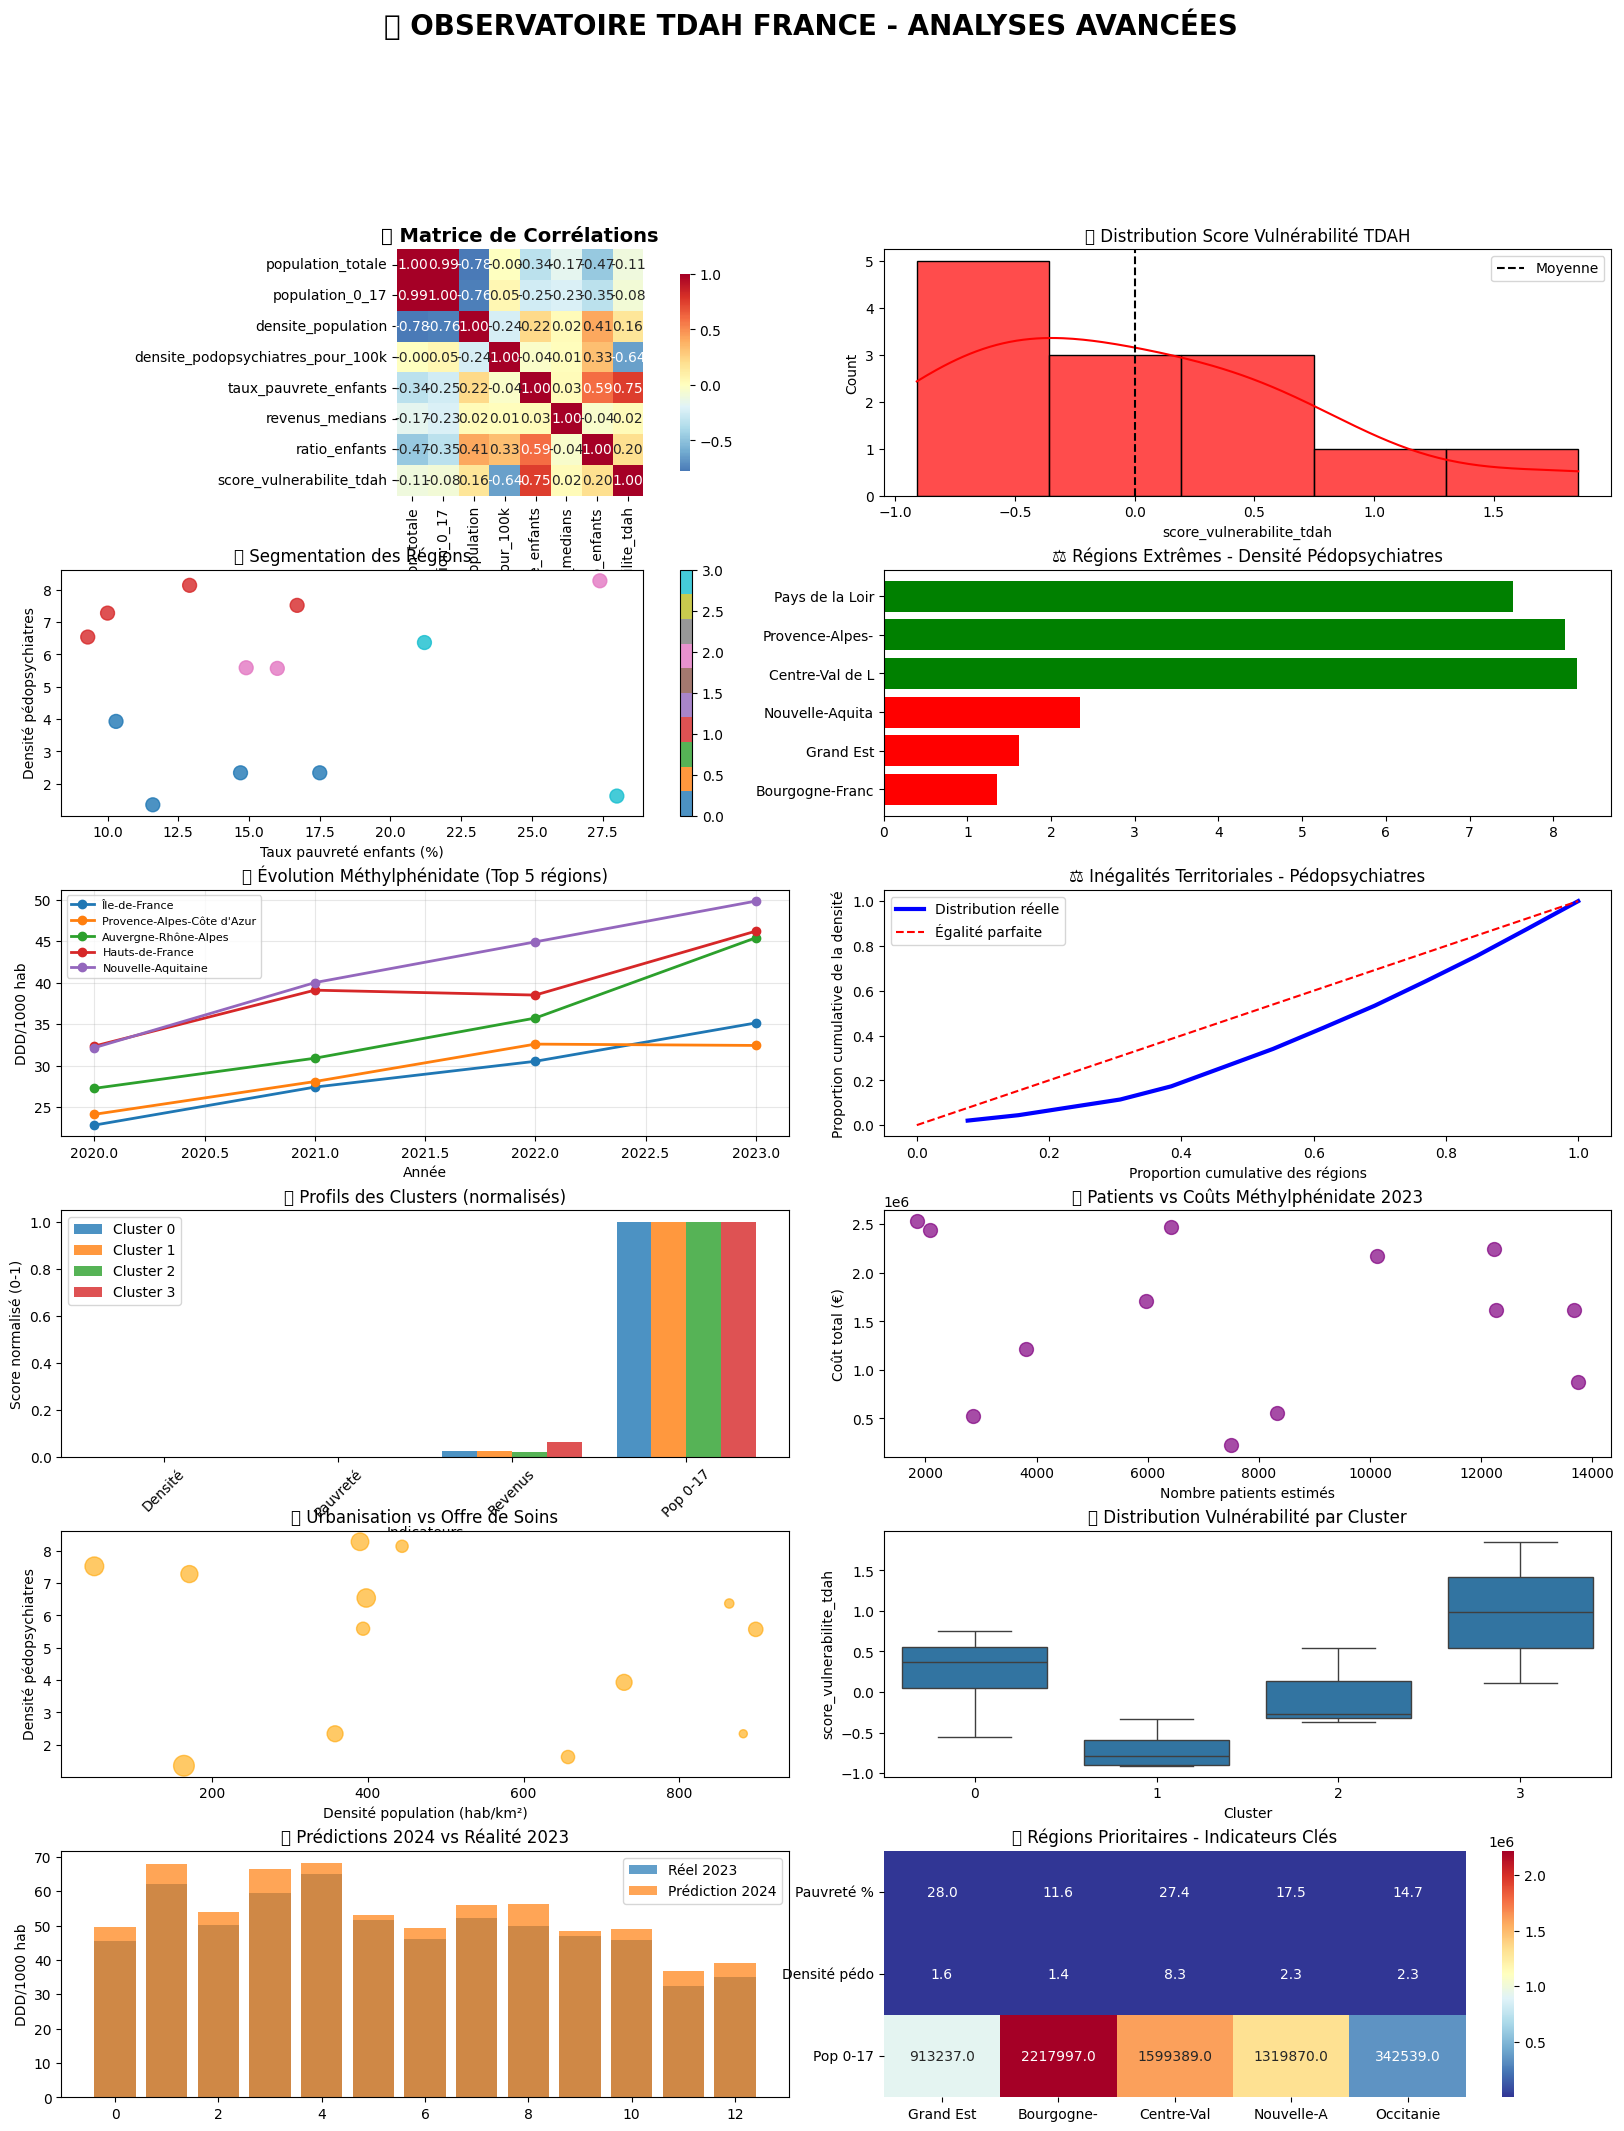

📊 12 visualisations avancées générées!


In [4]:
# ================================================================
# VISUALISATIONS AVANCÉES (12 GRAPHIQUES SUPPLÉMENTAIRES)
# ================================================================

fig = plt.figure(figsize=(20, 24))
gs = fig.add_gridspec(6, 4, hspace=0.3, wspace=0.3)

# 1. Heatmap de corrélations
ax1 = fig.add_subplot(gs[0, :2])
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.2f', square=True, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('🔗 Matrice de Corrélations', fontsize=14, fontweight='bold')

# 2. Distribution du score de vulnérabilité
ax2 = fig.add_subplot(gs[0, 2:])
sns.histplot(master_data['score_vulnerabilite_tdah'], kde=True, ax=ax2, color='red', alpha=0.7)
ax2.set_title('📊 Distribution Score Vulnérabilité TDAH', fontsize=12)
ax2.axvline(master_data['score_vulnerabilite_tdah'].mean(), color='black', linestyle='--', label='Moyenne')
ax2.legend()

# 3. Segmentation des régions (scatter plot)
ax3 = fig.add_subplot(gs[1, :2])
scatter = ax3.scatter(master_data['taux_pauvrete_enfants'], 
                     master_data['densite_podopsychiatres_pour_100k'],
                     c=master_data['cluster'], cmap='tab10', s=100, alpha=0.8)
ax3.set_xlabel('Taux pauvreté enfants (%)')
ax3.set_ylabel('Densité pédopsychiatres')
ax3.set_title('🎯 Segmentation des Régions')
plt.colorbar(scatter, ax=ax3)

# 4. Top/Bottom régions densité soins
ax4 = fig.add_subplot(gs[1, 2:])
top_bottom = pd.concat([
    master_data.nsmallest(3, 'densite_podopsychiatres_pour_100k'),
    master_data.nlargest(3, 'densite_podopsychiatres_pour_100k')
])
bars = ax4.barh(range(len(top_bottom)), top_bottom['densite_podopsychiatres_pour_100k'], 
                color=['red']*3 + ['green']*3)
ax4.set_yticks(range(len(top_bottom)))
ax4.set_yticklabels([r[:15] for r in top_bottom['region']], fontsize=10)
ax4.set_title('⚖️ Régions Extrêmes - Densité Pédopsychiatres')

# 5. Évolution temporelle avec projections
ax5 = fig.add_subplot(gs[2, :2])
for region in df_methylphenidate['region'].unique()[:5]:  # Top 5 pour lisibilité
    data_region = df_methylphenidate[df_methylphenidate['region'] == region]
    ax5.plot(data_region['annee'], data_region['consommation_ddd_par_1000_hab'], 
             marker='o', linewidth=2, label=region)
ax5.set_title('📈 Évolution Méthylphénidate (Top 5 régions)')
ax5.set_xlabel('Année')
ax5.set_ylabel('DDD/1000 hab')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Analyse des inégalités (courbe de Lorenz simplifiée)
ax6 = fig.add_subplot(gs[2, 2:])
densites_sorted = sorted(master_data['densite_podopsychiatres_pour_100k'])
cumul_normalized = np.cumsum(densites_sorted) / sum(densites_sorted)
pop_cumul = np.arange(1, len(densites_sorted)+1) / len(densites_sorted)
ax6.plot(pop_cumul, cumul_normalized, 'b-', linewidth=3, label='Distribution réelle')
ax6.plot([0, 1], [0, 1], 'r--', label='Égalité parfaite')
ax6.set_title('⚖️ Inégalités Territoriales - Pédopsychiatres')
ax6.set_xlabel('Proportion cumulative des régions')
ax6.set_ylabel('Proportion cumulative de la densité')
ax6.legend()

# 7. Profil radar par cluster
ax7 = fig.add_subplot(gs[3, :2])
cluster_profiles_radar = master_data.groupby('cluster')[
    ['densite_podopsychiatres_pour_100k', 'taux_pauvrete_enfants', 'revenus_medians', 'population_0_17']
].mean()

# Normalisation pour le radar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
radar_data = scaler.fit_transform(cluster_profiles_radar.T).T

# Graphique en barres groupées (simplifié du radar)
x_pos = np.arange(len(cluster_profiles_radar.columns))
width = 0.2
for i, cluster in enumerate(cluster_profiles_radar.index):
    ax7.bar(x_pos + i*width, radar_data[i], width, 
           label=f'Cluster {cluster}', alpha=0.8)
ax7.set_xlabel('Indicateurs')
ax7.set_ylabel('Score normalisé (0-1)')
ax7.set_title('🕸️ Profils des Clusters (normalisés)')
ax7.set_xticks(x_pos + width * 1.5)
ax7.set_xticklabels(['Densité', 'Pauvreté', 'Revenus', 'Pop 0-17'], rotation=45)
ax7.legend()

# 8. Coûts et patients méthylphénidate 2023
ax8 = fig.add_subplot(gs[3, 2:])
data_2023 = df_methylphenidate[df_methylphenidate['annee'] == 2023]
ax8.scatter(data_2023['nb_patients_estimes'], data_2023['cout_total_euros'], 
           s=100, alpha=0.7, c='purple')
ax8.set_xlabel('Nombre patients estimés')
ax8.set_ylabel('Coût total (€)')
ax8.set_title('💰 Patients vs Coûts Méthylphénidate 2023')

# 9. Densité population vs densité pédopsychiatres
ax9 = fig.add_subplot(gs[4, :2])
ax9.scatter(master_data['densite_population'], master_data['densite_podopsychiatres_pour_100k'],
           s=master_data['population_0_17']/10000, alpha=0.6, c='orange')
ax9.set_xlabel('Densité population (hab/km²)')
ax9.set_ylabel('Densité pédopsychiatres')
ax9.set_title('🏙️ Urbanisation vs Offre de Soins')

# 10. Box plot comparatif par cluster
ax10 = fig.add_subplot(gs[4, 2:])
sns.boxplot(data=master_data, x='cluster', y='score_vulnerabilite_tdah', ax=ax10)
ax10.set_title('📦 Distribution Vulnérabilité par Cluster')
ax10.set_xlabel('Cluster')

# 11. Prédictions 2024 vs réalité 2023
ax11 = fig.add_subplot(gs[5, :2])
current_2023 = df_methylphenidate[df_methylphenidate['annee']==2023].groupby('region')['consommation_ddd_par_1000_hab'].first()
pred_merged = pred_df.set_index('region')['prediction_2024'].reindex(current_2023.index)

bars11 = ax11.bar(range(len(current_2023)), current_2023.values, alpha=0.7, label='Réel 2023')
bars11_pred = ax11.bar(range(len(pred_merged)), pred_merged.values, alpha=0.7, label='Prédiction 2024')
ax11.set_title('🔮 Prédictions 2024 vs Réalité 2023')
ax11.set_ylabel('DDD/1000 hab')
ax11.legend()

# 12. Synthèse régionale (top 5 indicateurs)
ax12 = fig.add_subplot(gs[5, 2:])
top_regions = master_data.nlargest(5, 'score_vulnerabilite_tdah')
indicators = ['taux_pauvrete_enfants', 'densite_podopsychiatres_pour_100k', 'population_0_17']
heatmap_data = top_regions[indicators].T

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlBu_r', 
           xticklabels=[r[:10] for r in top_regions['region']], 
           yticklabels=['Pauvreté %', 'Densité pédo', 'Pop 0-17'], ax=ax12)
ax12.set_title('🎯 Régions Prioritaires - Indicateurs Clés')

plt.suptitle('🏥 OBSERVATOIRE TDAH FRANCE - ANALYSES AVANCÉES', 
             fontsize=20, fontweight='bold', y=0.98)
plt.savefig('../../reports/figures/analyses_avancees_complete.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("📊 12 visualisations avancées générées!")
